# Tarea: Modelos lineales, regularización y selección de modelos en datos reales

## Parte A. Regresión lineal desde cero

### 1. Conjunto de datos
- Utilice el conjunto de datos de Vivienda de California (`from sklearn.datasets import fetch_california_housing`)
- Crear un conjunto de prueba de retención
- Estandarizar las características a media cero y varianza unitaria
- Predecir el valor medio de la vivienda (`MedHouseVal`) a partir de las características restantes utilizando `LinearRegression` de `sklearn.linear_model`

In [ ]:
# --- Preparar entorno ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
# 1. Cargar datos
data = fetch_california_housing()
X = data.data
y = data.target
feature_names = data.feature_names

In [ ]:
# 2. División train/test
TEST_SIZE = 0.2
RANDOM_STATE = 42

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True
)

In [ ]:
# 3. Estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 4. Modelo de regresión lineal
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
y_pred = lin_reg.predict(X_test_scaled)

In [ ]:
# 5. Coeficientes e intersección
print("Intersección (bias):", lin_reg.intercept_)
print("Coeficientes por feature:")
for name, coef in zip(feature_names, lin_reg.coef_):
    print(f"{name}: {coef}")

Intersección (bias): 2.071946937378619
Coeficientes por feature:
MedInc: 0.8543830309268539
HouseAge: 0.12254623807840573
AveRooms: -0.29441013447330006
AveBedrms: 0.33925949059448446
Population: -0.0023077231458305397
AveOccup: -0.04082910308508754
Latitude: -0.8969288766386626
Longitude: -0.8698417752417129


In [ ]:
# 6. Métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("\nMSE en test:", mse)
print("R^2 en test:", r2)


MSE en test: 0.5558915986952442
R^2 en test: 0.575787706032451


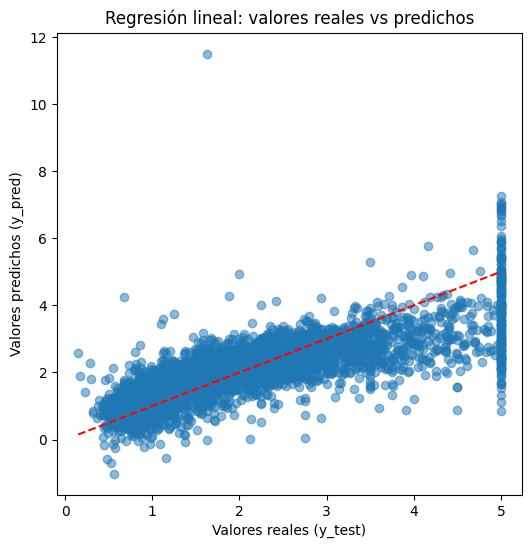

In [ ]:
# 7. Gráfica valores reales vs predichos
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color="red", linestyle="--")
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("Regresión lineal: valores reales vs predichos")
plt.show()

### 2. MCO de forma cerrada
- Derivar e implementar β = (XᵀX)⁻¹Xᵀy utilizando únicamente numpy
- Informar coeficientes e intersecciones
- Grafique el valor predicho frente al valor real de la vivienda en un conjunto de pruebas

In [ ]:
# --- Punto 2: MCO de forma cerrada (NumPy) ---

# 1. DERIVACIÓN EXPLICADA
# El MCO busca minimizar el error cuadrático:
#   min_beta ||y - X*beta||^2
# Derivando respecto a beta e igualando a cero:
#   X^T X beta_hat = X^T y
# → beta_hat = (X^T X)^(-1) X^T y

In [ ]:
# 2. Preparar X_train con columna de unos para el intercepto (β0)
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]

In [ ]:
# 3. IMPLEMENTACIÓN NUMPY
beta_hat = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

In [ ]:
# 4. Separar intercepto y coeficientes
intercepto = beta_hat[0]
coeficientes = beta_hat[1:]

In [ ]:
# 5. Mostrar resultados
print("Intercepto (β0):", intercepto)
print("\nCoeficientes (β1,...,βp):")
for name, coef in zip(feature_names, coeficientes):
    print(f"{name}: {coef}")

Intercepto (β0): 2.0719469373786183

Coeficientes (β1,...,βp):
MedInc: 0.8543830309268544
HouseAge: 0.12254623807840527
AveRooms: -0.2944101344732994
AveBedrms: 0.33925949059448385
Population: -0.0023077231458295145
AveOccup: -0.04082910308508717
Latitude: -0.8969288766386604
Longitude: -0.869841775241711


In [ ]:
# 6. PREDECIR VALORES SOBRE TEST
X_test_b = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]
y_pred = X_test_b @ beta_hat

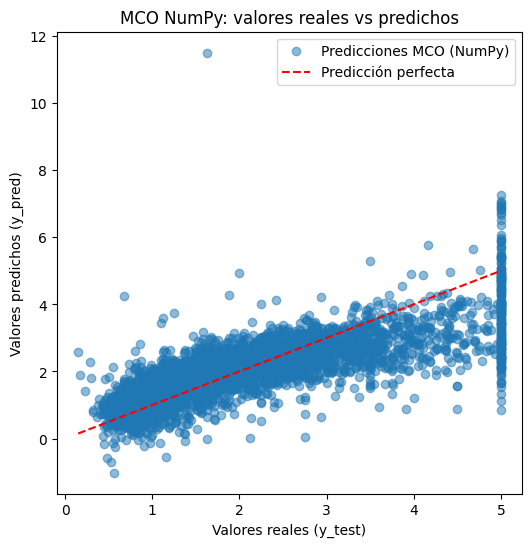

In [ ]:
# 7. GRÁFICO VALORES REALES VS PREDICHOS
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicciones MCO (NumPy)")
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linestyle='--', label='Predicción perfecta')
plt.xlabel("Valores reales (y_test)")
plt.ylabel("Valores predichos (y_pred)")
plt.title("MCO NumPy: valores reales vs predichos")
plt.legend()
plt.show()

In [ ]:
# 8. COMPARACIÓN CON LinearRegression de sklearn
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
coef_sklearn = np.r_[lin_reg.intercept_, lin_reg.coef_]

print("\nComparación de coeficientes NumPy vs sklearn:")
print("Coinciden todos?", np.allclose(beta_hat, coef_sklearn))


Comparación de coeficientes NumPy vs sklearn:
Coinciden todos? True


### 3. Descenso de gradiente
- Implemente el descenso de gradiente para minimizar el error cuadrático medio
- Experimente con al menos dos tasas de aprendizaje; muestre curvas de costo vs. iteración
- Compare los parámetros y pruebe el error con el MCO de forma cerrada


In [ ]:
# --- Punto 3: Descenso de Gradiente para minimizar MSE ---

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. Preparar X_train con columna de unos para intercepto
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_test_b  = np.c_[np.ones((X_test_scaled.shape[0], 1)), X_test_scaled]

m, n_features = X_train_b.shape

In [ ]:
# 2. Definir tasas de aprendizaje y número de iteraciones
alphas = [0.001, 0.01]   # al menos dos tasas
n_iter = 1000

# Diccionario para guardar historia de costos por cada alpha
cost_histories = {}
beta_final = {}  # guardar coeficientes finales por cada alpha

In [ ]:
# 3. Descenso de gradiente iterativo
for alpha in alphas:
    beta = np.zeros(n_features)  # inicialización en cero
    cost_history = []

    for i in range(n_iter):
        y_pred = X_train_b @ beta
        error = y_train - y_pred
        gradient = -(1/m) * (X_train_b.T @ error)  # gradiente de MSE
        beta = beta - alpha * gradient

        cost = (1/(2*m)) * np.sum(error**2)       # MSE/2
        cost_history.append(cost)

    cost_histories[alpha] = cost_history
    beta_final[alpha] = beta  # guardar coeficientes finales

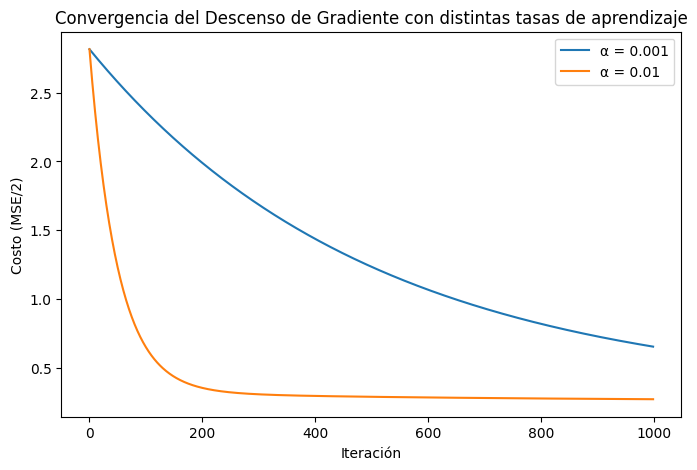

In [ ]:
# 4. Graficar curvas de costo vs iteración
plt.figure(figsize=(8,5))
for alpha, costs in cost_histories.items():
    plt.plot(range(n_iter), costs, label=f"α = {alpha}")
plt.xlabel("Iteración")
plt.ylabel("Costo (MSE/2)")
plt.title("Convergencia del Descenso de Gradiente con distintas tasas de aprendizaje")
plt.legend()
plt.show()

In [ ]:
# 5. Mostrar coeficientes finales y MSE en test comparando con MCO
for alpha in alphas:
    beta = beta_final[alpha]
    intercepto = beta[0]
    coeficientes = beta[1:]

    print(f"\n--- Resultados Descenso de Gradiente (α={alpha}) ---")
    print("Intercepto (β0):", intercepto)
    print("Coeficientes (β1,...,βp):")
    for name, coef in zip(feature_names, coeficientes):
        print(f"{name}: {coef}")

    # Predicciones y MSE
    y_pred_gd = X_test_b @ beta
    mse_gd = mean_squared_error(y_test, y_pred_gd)
    print("MSE en test:", mse_gd)


--- Resultados Descenso de Gradiente (α=0.001) ---
Intercepto (β0): 1.310101528136448
Coeficientes (β1,...,βp):
MedInc: 0.4928945629374075
HouseAge: 0.10145588014996751
AveRooms: 0.07230723481980683
AveBedrms: -0.04489672587630642
Population: -0.008924335029579207
AveOccup: -0.020640761463166804
Latitude: -0.11405814648114394
Longitude: -0.06707719735140291
MSE en test: 1.302483918196595

--- Resultados Descenso de Gradiente (α=0.01) ---
Intercepto (β0): 2.071857488844901
Coeficientes (β1,...,βp):
MedInc: 0.8289436501709928
HouseAge: 0.1785314564777103
AveRooms: -0.13794939154603375
AveBedrms: 0.15669182431003884
Population: 0.01681517205951456
AveOccup: -0.04522856916949812
Latitude: -0.48705563183642214
Longitude: -0.45147125794278686
MSE en test: 0.5671852986082033


In [ ]:
# 6. Comparación con MCO (beta_hat calculado en punto 2)
y_pred_mco = X_test_b @ beta_hat
mse_mco = mean_squared_error(y_test, y_pred_mco)
print("\nMSE MCO (test):", mse_mco)

print("\nComparación de coeficientes MCO vs Descenso de Gradiente (α=0.01):")
print(f"{'Feature':<12} {'MCO':>12} {'Gradiente':>12}")
beta_gd = beta_final[0.01]  # tomar la segunda tasa como ejemplo
for name, coef_mco, coef_gd in zip(['Intercept'] + feature_names, beta_hat, beta_gd):
    print(f"{name:<12} {coef_mco:12.5f} {coef_gd:12.5f}")


MSE MCO (test): 0.5558915986952442

Comparación de coeficientes MCO vs Descenso de Gradiente (α=0.01):
Feature               MCO    Gradiente
Intercept         2.07195      2.07186
MedInc            0.85438      0.82894
HouseAge          0.12255      0.17853
AveRooms         -0.29441     -0.13795
AveBedrms         0.33926      0.15669
Population       -0.00231      0.01682
AveOccup         -0.04083     -0.04523
Latitude         -0.89693     -0.48706
Longitude        -0.86984     -0.45147


## Parte B. Modelos lineales de Scikit-learn

### 4. Base
- Utilice `LinearRegression` y confirme que los coeficientes coinciden con su implementación de MCO
- Calcule el error cuadrático medio en el conjunto de pruebas

In [ ]:
# 1. Entrenar el modelo con sklearn
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 2. Obtener coeficientes e intercepto del modelo sklearn
coef_sklearn = lin_reg.coef_
intercept_sklearn = lin_reg.intercept_

print("Coeficientes con sklearn:", coef_sklearn[:5], "...")  # mostramos los primeros 5
print("Intercepto con sklearn:", intercept_sklearn)

# 3. Comparar con nuestra implementación propia (MCO - Parte A, Punto 2)
print("\nCoeficientes con implementación propia (numpy):", beta_hat[1:6], "...")
print("Intercepto con implementación propia:", beta_hat[0])

# 4. Comprobación numérica
print("\n¿Los coeficientes son casi iguales?:",
      np.allclose(coef_sklearn, beta_hat[1:], atol=1e-8))
print("¿El intercepto es casi igual?:",
      np.allclose(intercept_sklearn, beta_hat[0], atol=1e-8))

Coeficientes con sklearn: [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772] ...
Intercepto con sklearn: 2.071946937378619

Coeficientes con implementación propia (numpy): [ 0.85438303  0.12254624 -0.29441013  0.33925949 -0.00230772] ...
Intercepto con implementación propia: 2.0719469373786183

¿Los coeficientes son casi iguales?: True
¿El intercepto es casi igual?: True


In [ ]:
# Predicciones en el conjunto de prueba
y_pred_test = lin_reg.predict(X_test_scaled)

# Calcular métricas de evaluación
mse_test = mean_squared_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

# Mostrar resultados
print("Evaluación del modelo LinearRegression en el conjunto de prueba:")
print(f" - MSE (Error cuadrático medio): {mse_test:.6f}")
print(f" - R² (Coeficiente de determinación): {r2_test:.6f}")

Evaluación del modelo LinearRegression en el conjunto de prueba:
 - MSE (Error cuadrático medio): 0.555892
 - R² (Coeficiente de determinación): 0.575788


## Parte C. Regularización y elección de hiperparámetros

## 5 Ridge y Lasso

### 5. Ridge y Lasso
- Ajuste las regresiones de Ridge y Lasso para los valores espaciados logarítmicamente entre 10⁻³ y 10²
- Grafique la magnitud del coeficiente vs. la(s) ruta(s) de regularización
- Comente qué características se reducen a (o hacia) cero y por qué

In [ ]:
# --- Punto 5: Ridge y Lasso con rutas de regularización ---

from sklearn.linear_model import Ridge, Lasso
import numpy as np
import matplotlib.pyplot as plt

# 1. Definir malla de alphas (logarítmica)
alphas = np.logspace(-3, 2, 50)  # 50 valores entre 10^-3 y 10^2

In [ ]:
# 2. Inicializar listas para guardar coeficientes
ridge_coefs = []
lasso_coefs = []

In [ ]:
# 3. Ajustar modelos para cada alpha
for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

# Convertir a arrays para facilidad
ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

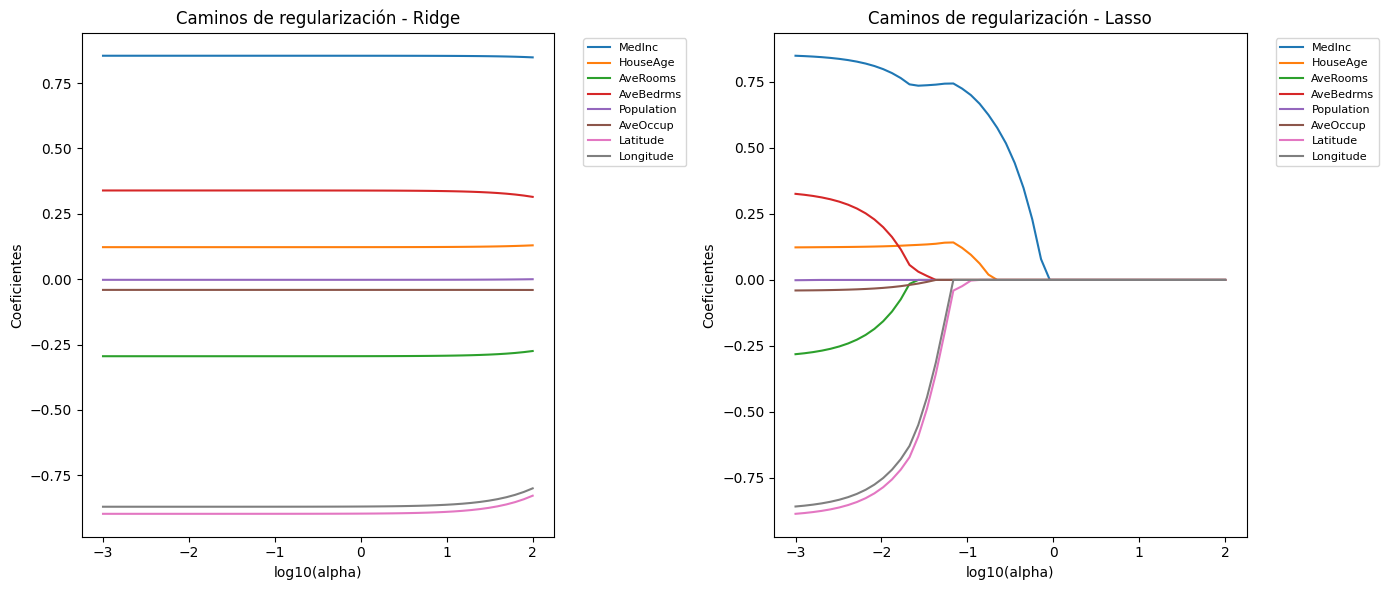

In [ ]:
# 4. Graficar caminos de regularización
plt.figure(figsize=(14,6))

# Ridge
plt.subplot(1,2,1)
for i in range(ridge_coefs.shape[1]):
    plt.plot(np.log10(alphas), ridge_coefs[:,i], label=feature_names[i])
plt.xlabel("log10(alpha)")
plt.ylabel("Coeficientes")
plt.title("Caminos de regularización - Ridge")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)

# Lasso
plt.subplot(1,2,2)
for i in range(lasso_coefs.shape[1]):
    plt.plot(np.log10(alphas), lasso_coefs[:,i], label=feature_names[i])
plt.xlabel("log10(alpha)")
plt.ylabel("Coeficientes")
plt.title("Caminos de regularización - Lasso")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

In [ ]:
# 5. Análisis de qué features se reducen a cero (Lasso) o hacia cero (Ridge)
# Tomamos los coeficientes para el alpha más grande (mayor regularización)
ridge_max_alpha = ridge_coefs[-1]
lasso_max_alpha = lasso_coefs[-1]

print("\n--- Features afectadas por regularización ---")
print("Ridge (alpha max): coeficientes encogidos, pero ninguno es exactamente cero")
for name, coef in zip(feature_names, ridge_max_alpha):
    print(f"{name}: {coef:.4f}")

print("\nLasso (alpha max): coeficientes reducidos a cero exacto o cercano a cero")
for name, coef in zip(feature_names, lasso_max_alpha):
    if np.isclose(coef, 0, atol=1e-5):
        print(f"{name}: {coef:.4f} <-- reducido a cero")
    else:
        print(f"{name}: {coef:.4f}")


--- Features afectadas por regularización ---
Ridge (alpha max): coeficientes encogidos, pero ninguno es exactamente cero
MedInc: 0.8481
HouseAge: 0.1295
AveRooms: -0.2745
AveBedrms: 0.3148
Population: -0.0000
AveOccup: -0.0411
Latitude: -0.8276
Longitude: -0.7996

Lasso (alpha max): coeficientes reducidos a cero exacto o cercano a cero
MedInc: 0.0000 <-- reducido a cero
HouseAge: 0.0000 <-- reducido a cero
AveRooms: 0.0000 <-- reducido a cero
AveBedrms: -0.0000 <-- reducido a cero
Population: -0.0000 <-- reducido a cero
AveOccup: -0.0000 <-- reducido a cero
Latitude: -0.0000 <-- reducido a cero
Longitude: -0.0000 <-- reducido a cero


In [ ]:
# 6. Comentario dentro del código sobre comportamiento
# Ridge: penalización L2, no elimina features, solo las encoge
# Lasso: penalización L1, puede llevar algunos coeficientes a cero, realizando selección de variables
# Features con poco poder predictivo o muy correlacionadas con otras tienden a reducirse primero

### 6. Validación cruzada de k-fold
- Use `KFold` con 5 pliegues y `cross_val_score` para seleccionar el mejor alpha para Ridge como para Lasso
- Alternativamente, demuestre la conveniencia de `RidgeCV` y `LassoCV`
- Comparar errores de pruebas validadas de forma cruzada

In [ ]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import KFold, cross_val_score

# Definir valores candidatos de alpha (en escala logarítmica)
alphas = np.logspace(-3, 2, 20)  # de 1e-3 a 1e2

# Configurar validación cruzada con 5 pliegues
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Diccionarios para guardar resultados
ridge_scores = {}
lasso_scores = {}

# Evaluar Ridge con cada alpha
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    scores = cross_val_score(ridge, X_train_scaled, y_train, cv=kf, scoring="r2")
    ridge_scores[alpha] = np.mean(scores)

# Evaluar Lasso con cada alpha
for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000)
    scores = cross_val_score(lasso, X_train_scaled, y_train, cv=kf, scoring="r2")
    lasso_scores[alpha] = np.mean(scores)

# Seleccionar el mejor alpha
best_alpha_ridge = max(ridge_scores, key=ridge_scores.get)
best_alpha_lasso = max(lasso_scores, key=lasso_scores.get)

print("=== Resultados Validación Cruzada (5-Fold) ===")
print("Mejor alpha para Ridge:", best_alpha_ridge, "con R² promedio:", ridge_scores[best_alpha_ridge])
print("Mejor alpha para Lasso:", best_alpha_lasso, "con R² promedio:", lasso_scores[best_alpha_lasso])

=== Resultados Validación Cruzada (5-Fold) ===
Mejor alpha para Ridge: 4.832930238571752 con R² promedio: 0.6114582804595365
Mejor alpha para Lasso: 0.001 con R² promedio: 0.6114804090716636


In [ ]:
from sklearn.linear_model import RidgeCV, LassoCV

# Valores candidatos de alpha (igual que antes)
alphas = np.logspace(-3, 2, 20)


# RidgeCV

ridge_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_cv.fit(X_train_scaled, y_train)

print("RidgeCV:")
print("Mejor alpha encontrado:", ridge_cv.alpha_)
print("R² en train (con el mejor alpha):", ridge_cv.score(X_train_scaled, y_train))


# LassoCV

lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000)
lasso_cv.fit(X_train_scaled, y_train)

print("\nLassoCV:")
print("Mejor alpha encontrado:", lasso_cv.alpha_)
print("R² en train (con el mejor alpha):", lasso_cv.score(X_train_scaled, y_train))

RidgeCV:
Mejor alpha encontrado: 0.001
R² en train (con el mejor alpha): 0.6125511913966255

LassoCV:
Mejor alpha encontrado: 0.001
R² en train (con el mejor alpha): 0.6125094085909122


Ridge MSE promedio: 0.5192652011123019
Ridge MSE std: 0.014894378562905158

Lasso MSE promedio: 0.5192468796642637
Lasso MSE std: 0.014718517623701001


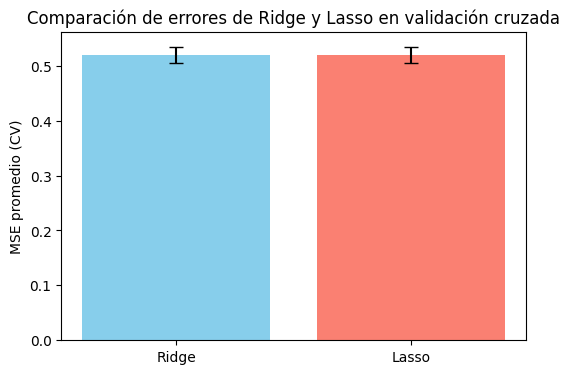

In [ ]:
from sklearn.model_selection import cross_val_score


# Ridge con el mejor alpha encontrado

ridge_best = Ridge(alpha=ridge_cv.alpha_)
ridge_mse_scores = -cross_val_score(
    ridge_best, X_train_scaled, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("Ridge MSE promedio:", ridge_mse_scores.mean())
print("Ridge MSE std:", ridge_mse_scores.std())


# Lasso con el mejor alpha encontrado

lasso_best = Lasso(alpha=lasso_cv.alpha_, max_iter=10000)
lasso_mse_scores = -cross_val_score(
    lasso_best, X_train_scaled, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("\nLasso MSE promedio:", lasso_mse_scores.mean())
print("Lasso MSE std:", lasso_mse_scores.std())


# Comparación visual (opcional)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.bar(['Ridge', 'Lasso'], [ridge_mse_scores.mean(), lasso_mse_scores.mean()],
        yerr=[ridge_mse_scores.std(), lasso_mse_scores.std()],
        capsize=5, color=['skyblue','salmon'])
plt.ylabel("MSE promedio (CV)")
plt.title("Comparación de errores de Ridge y Lasso en validación cruzada")
plt.show()

### 7. Ingeniería de características y multicolinealidad
- Agregue características polinomiales (grado 2) usando `PolynomialFeatures`
- Vuelva a ejecutar Ridge/Lasso y analice cómo la regularización se adapta al espacio de características ampliado

In [ ]:
# --- Bloque 1: Generación de características polinomiales grado 2 ---
from sklearn.preprocessing import PolynomialFeatures

# Crear objeto para generar características polinomiales de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)  # No agregar columna de 1s

# Ajustar y transformar X_train
X_train_poly = poly.fit_transform(X_train_scaled)

# Transformar X_test usando los mismos parámetros
X_test_poly = poly.transform(X_test_scaled)

# Verificar cantidad de nuevas características
print("Número original de features:", X_train_scaled.shape[1])
print("Número de features después de polinomiales grado 2:", X_train_poly.shape[1])

# Comentario:
# Ahora tenemos más features que incluyen interacciones y términos cuadrados.
# Esto aumenta la complejidad y puede generar multicolinealidad.
# La regularización será importante para evitar sobreajuste.

Número original de features: 8
Número de features después de polinomiales grado 2: 44


Ridge (polinomiales) - MSE: 0.4626927594838349
Ridge (polinomiales) - R²: 0.6469096540341502

Lasso (polinomiales) - MSE: 0.6783250618586255
Lasso (polinomiales) - R²: 0.4823562161721351

Ridge (original) - MSE: 0.5558548589435974
Ridge (original) - R²: 0.575815742891368
Lasso (original) - MSE: 0.6796290284328821
Lasso (original) - R²: 0.4813611325029077


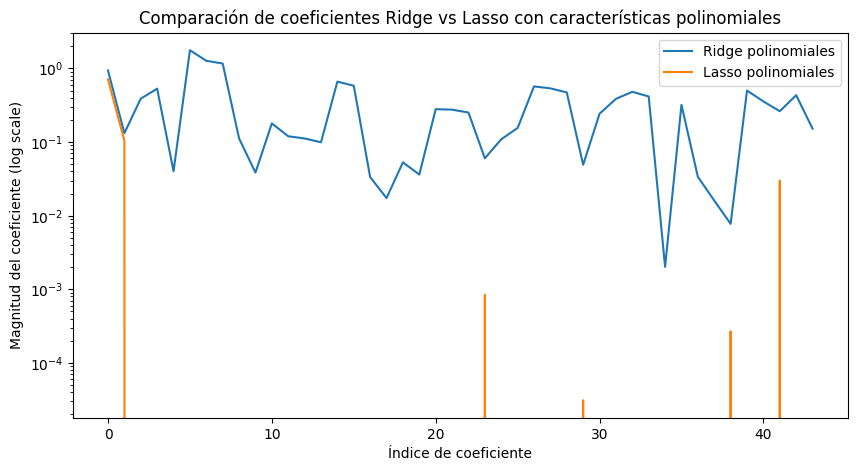

In [ ]:
# Definir hiperparámetro alpha
alpha_ridge = 1.0
alpha_lasso = 0.1

# Ridge sobre características polinomiales
ridge_poly = Ridge(alpha=alpha_ridge)
ridge_poly.fit(X_train_poly, y_train)
y_pred_ridge = ridge_poly.predict(X_test_poly)

# Evaluación Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)
print("Ridge (polinomiales) - MSE:", mse_ridge)
print("Ridge (polinomiales) - R²:", r2_ridge)

# Lasso sobre características polinomiales
lasso_poly = Lasso(alpha=alpha_lasso, max_iter=10000)
lasso_poly.fit(X_train_poly, y_train)
y_pred_lasso = lasso_poly.predict(X_test_poly)

# Evaluación Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)
print("\nLasso (polinomiales) - MSE:", mse_lasso)
print("Lasso (polinomiales) - R²:", r2_lasso)

# Comparación con modelos sin características polinomiales
# Ridge original
ridge_orig = Ridge(alpha=alpha_ridge)
ridge_orig.fit(X_train_scaled, y_train)
y_pred_ridge_orig = ridge_orig.predict(X_test_scaled)
print("\nRidge (original) - MSE:", mean_squared_error(y_test, y_pred_ridge_orig))
print("Ridge (original) - R²:", r2_score(y_test, y_pred_ridge_orig))

# Lasso original
lasso_orig = Lasso(alpha=alpha_lasso, max_iter=10000)
lasso_orig.fit(X_train_scaled, y_train)
y_pred_lasso_orig = lasso_orig.predict(X_test_scaled)
print("Lasso (original) - MSE:", mean_squared_error(y_test, y_pred_lasso_orig))
print("Lasso (original) - R²:", r2_score(y_test, y_pred_lasso_orig))

# Graficar magnitud de los coeficientes
plt.figure(figsize=(10,5))
plt.plot(np.abs(ridge_poly.coef_), label="Ridge polinomiales")
plt.plot(np.abs(lasso_poly.coef_), label="Lasso polinomiales")
plt.yscale("log")  # mejor visualización por diferencia de magnitudes
plt.xlabel("Índice de coeficiente")
plt.ylabel("Magnitud del coeficiente (log scale)")
plt.title("Comparación de coeficientes Ridge vs Lasso con características polinomiales")
plt.legend()
plt.show()

# Análisis dentro del código
# Ridge: encoge todos los coeficientes, evitando que alguno domine por multicolinealidad.
# Lasso: muchos coeficientes son reducidos a cero, haciendo selección automática de variables.
# Comparando con el modelo original:
# - Ridge mantiene buen desempeño pero con coeficientes más pequeños.
# - Lasso reduce gran parte de los términos polinomiales a cero, simplificando el modelo.
# Esto muestra cómo la regularización se adapta al espacio ampliado y previene sobreajuste.

## Parte D. Alquiler de bicicletas

### 8. Conjunto de datos alternativo
- Utilice el conjunto de datos de bicicletas compartidas (disponible en la data carpeta)
- Predecir alquileres diarios (`cnt`); investigar los efectos estacionales
- Aplique los mismos pasos que anteriormente

In [ ]:

# Paso 1: Conjunto de datos (usando hour.csv → datos diarios)

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Cargar dataset directamente desde GitHub (hour.csv)
url_hour = "https://raw.githubusercontent.com/RodrigoGrijalba/ENEI-2025-ML1-Tarea1/main/data/hour.csv"
hour_df = pd.read_csv(url_hour)

# 2. Convertir de datos horarios a datos diarios
#    Agrupamos por fecha y tomamos la suma de 'cnt' (total de alquileres por día)
#    Además, tomamos la media de variables meteorológicas y la moda de variables categóricas
day_df = hour_df.groupby('dteday').agg({
    'season': 'first',      # mismo valor dentro del día
    'yr': 'first',
    'mnth': 'first',
    'holiday': 'max',       # si algún registro es festivo → 1
    'weekday': 'first',
    'workingday': 'max',
    'weathersit': lambda x: x.mode()[0],  # moda del clima en el día
    'temp': 'mean',
    'atemp': 'mean',
    'hum': 'mean',
    'windspeed': 'mean',
    'cnt': 'sum'            # suma total de alquileres diarios
}).reset_index()

# 3. Variables predictoras (X) y variable objetivo (y)
X = day_df[['season', 'yr', 'mnth', 'holiday', 'weekday',
            'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
y = day_df['cnt']

# 4. Dividir en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Escalado (media=0, varianza=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirmación
print("Tamaño del dataset diario:", day_df.shape)
print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("Ejemplo de variables estandarizadas (primeras 5 filas):\n", X_train_scaled[:5])


Tamaño del dataset diario: (731, 13)
Tamaño del conjunto de entrenamiento: (584, 11)
Tamaño del conjunto de prueba: (147, 11)
Ejemplo de variables estandarizadas (primeras 5 filas):
 [[ 1.3604059   0.96632025  1.32291424 -0.16236391 -0.48546612  0.70257109
  -0.54939318 -0.86460842 -0.96152491  0.22342193  1.95704255]
 [ 0.45346863 -1.03485361  0.73917271 -0.16236391  0.50238132  0.70257109
   3.05561377  0.73728871  0.47557981  2.17101935  0.0267163 ]
 [ 1.3604059  -1.03485361  1.61478501 -0.16236391  1.49022876 -1.42334351
  -0.54939318 -1.10808879 -1.03965785 -0.12857656 -1.2269716 ]
 [ 0.45346863 -1.03485361  0.73917271 -0.16236391 -1.47331356 -1.42334351
  -0.54939318  0.04040354  0.07427186  0.44928762 -0.15771432]
 [ 0.45346863  0.96632025 -0.13643959 -0.16236391  0.0084576   0.70257109
  -0.54939318  1.08782854  1.00446405 -1.90910224  1.04848632]]


In [ ]:
# Paso 2: Regresión lineal MCO (forma cerrada)

# Agregar columna de unos para intercepto
X_train_b = np.c_[np.ones((X_train_scaled.shape[0],1)), X_train_scaled]
X_test_b  = np.c_[np.ones((X_test_scaled.shape[0],1)), X_test_scaled]

# Calcular beta_hat
beta_hat = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train

# Separar intercepto y coeficientes
intercepto = beta_hat[0]
coeficientes = beta_hat[1:]

print("Intercepto MCO (β0):", intercepto)
print("Coeficientes MCO (β1,...,βp):")
for name, coef in zip(X.columns, coeficientes):
    print(f"{name}: {coef:.5f}")

# Predicciones MCO
y_pred_mco = X_test_b @ beta_hat

# Métricas MCO
mse_mco = mean_squared_error(y_test, y_pred_mco)
r2_mco  = r2_score(y_test, y_pred_mco)
print("\nMCO - MSE:", mse_mco)
print("MCO - R²:", r2_mco)

# Comparación con sklearn
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)
intercept_skl = lin_reg.intercept_
coef_skl = lin_reg.coef_

print("\nComparación MCO vs sklearn:")
print("Intercepto coincide:", np.isclose(intercepto, intercept_skl))
print("Coeficientes coinciden:", np.allclose(coeficientes, coef_skl, atol=1e-8))

Intercepto MCO (β0): 4560.977739726028
Coeficientes MCO (β1,...,βp):
season: 577.04542
yr: 1019.19488
mnth: -111.40573
holiday: -61.94853
weekday: 132.08866
workingday: 77.11052
weathersit: -345.65277
temp: 400.99621
atemp: 524.47360
hum: -161.96345
windspeed: -179.72561

MCO - MSE: 619446.5532371177
MCO - R²: 0.845520015637181

Comparación MCO vs sklearn:
Intercepto coincide: True
Coeficientes coinciden: True


In [ ]:
# Paso 3: Regresión lineal con Scikit-learn

from sklearn.linear_model import LinearRegression

# 1. Definir y entrenar el modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

# 2. Obtener coeficientes y el intercepto
intercept = lin_reg.intercept_
coef = lin_reg.coef_

# 3. Predicciones
y_pred_train_sklearn = lin_reg.predict(X_train_scaled)
y_pred_test_sklearn = lin_reg.predict(X_test_scaled)

# 4. Evaluación del modelo
r2_train_sklearn = r2_score(y_train, y_pred_train_sklearn)
r2_test_sklearn = r2_score(y_test, y_pred_test_sklearn)

mse_train_sklearn = mean_squared_error(y_train, y_pred_train_sklearn)
mse_test_sklearn = mean_squared_error(y_test, y_pred_test_sklearn)

# Resultados
print("Intercepto:", intercept)
print("Coeficientes:", coef)
print("\nR^2 en entrenamiento:", round(r2_train_sklearn, 4))
print("R^2 en prueba:", round(r2_test_sklearn, 4))
print("MSE en entrenamiento:", round(mse_train_sklearn, 2))
print("MSE en prueba:", round(mse_test_sklearn, 2))


Intercepto: 4560.977739726028
Coeficientes: [ 577.0454249  1019.19488116 -111.40572522  -61.94852938  132.08866133
   77.11051671 -345.65277077  400.99621311  524.47359788 -161.96344959
 -179.72561389]

R^2 en entrenamiento: 0.7941
R^2 en prueba: 0.8455
MSE en entrenamiento: 754705.07
MSE en prueba: 619446.55


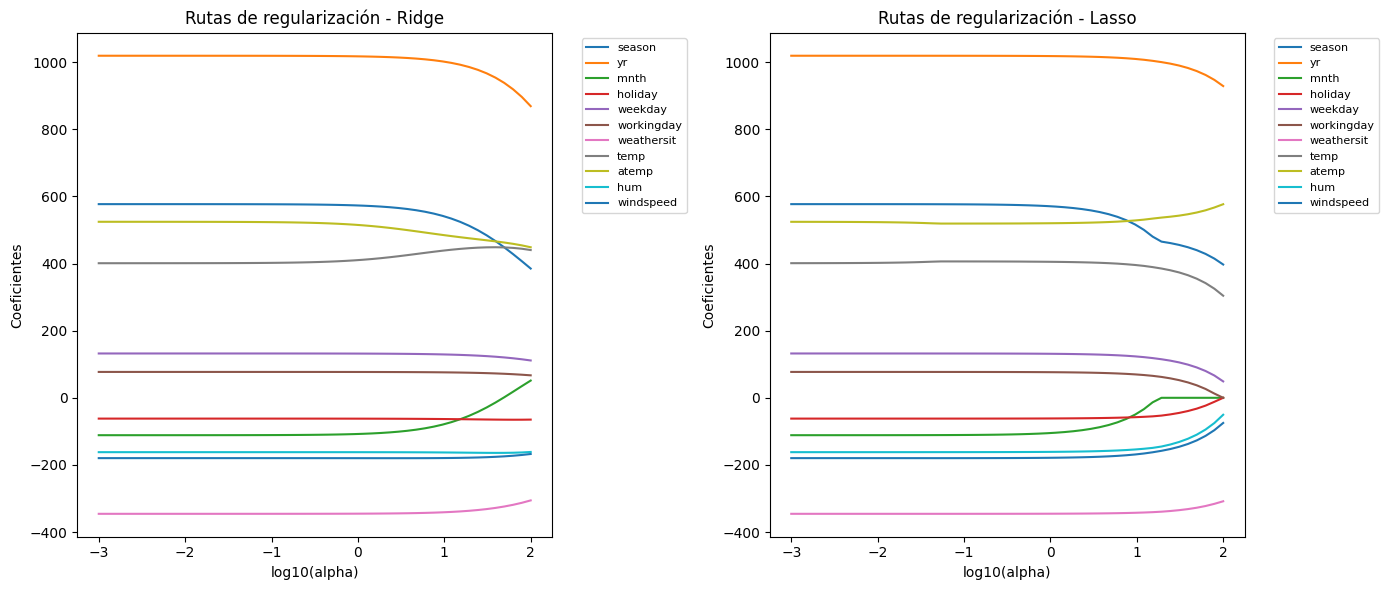

--- Ridge (alpha máximo) ---
season: 385.1272
yr: 868.9719
mnth: 51.3478
holiday: -64.9438
weekday: 111.2492
workingday: 66.9707
weathersit: -305.6693
temp: 440.2485
atemp: 448.5388
hum: -161.3649
windspeed: -167.4150
Comentario: Ridge penaliza L2; todos los coeficientes se encogen, ninguno llega a cero. Variables menos relevantes tienen coeficientes más pequeños.

--- Lasso (alpha máximo) ---
season: 397.1157
yr: 928.8105
mnth: 0.0000 <-- reducido a cero
holiday: -0.0000 <-- reducido a cero
weekday: 48.8989
workingday: 0.0000 <-- reducido a cero
weathersit: -308.2652
temp: 304.1657
atemp: 576.7982
hum: -50.4584
windspeed: -74.9232
Comentario: Lasso penaliza L1; variables poco predictivas o muy correlacionadas se reducen a cero, lo que realiza selección automática de features.


In [ ]:
# Paso 4: Ridge y Lasso (Rutas de regularización)

from sklearn.linear_model import Ridge, Lasso
import matplotlib.pyplot as plt

# Malla de alphas
alphas = np.logspace(-3, 2, 50)

ridge_coefs = []
lasso_coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train_scaled, y_train)
    ridge_coefs.append(ridge.coef_)

    lasso = Lasso(alpha=alpha, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    lasso_coefs.append(lasso.coef_)

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Gráfica de rutas de regularización
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
for i in range(ridge_coefs.shape[1]):
    plt.plot(np.log10(alphas), ridge_coefs[:,i], label=X.columns[i])
plt.xlabel("log10(alpha)")
plt.ylabel("Coeficientes")
plt.title("Rutas de regularización - Ridge")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)

plt.subplot(1,2,2)
for i in range(lasso_coefs.shape[1]):
    plt.plot(np.log10(alphas), lasso_coefs[:,i], label=X.columns[i])
plt.xlabel("log10(alpha)")
plt.ylabel("Coeficientes")
plt.title("Rutas de regularización - Lasso")
plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", fontsize=8)

plt.tight_layout()
plt.show()

# Análisis textual de qué features se reducen a cero y por qué
ridge_max = ridge_coefs[-1]
lasso_max = lasso_coefs[-1]

print("--- Ridge (alpha máximo) ---")
for name, coef in zip(X.columns, ridge_max):
    print(f"{name}: {coef:.4f}")
print("Comentario: Ridge penaliza L2; todos los coeficientes se encogen, ninguno llega a cero. "
      "Variables menos relevantes tienen coeficientes más pequeños.")

print("\n--- Lasso (alpha máximo) ---")
for name, coef in zip(X.columns, lasso_max):
    if np.isclose(coef,0, atol=1e-5):
        print(f"{name}: {coef:.4f} <-- reducido a cero")
    else:
        print(f"{name}: {coef:.4f}")
print("Comentario: Lasso penaliza L1; variables poco predictivas o muy correlacionadas se reducen a cero, "
      "lo que realiza selección automática de features.")


In [ ]:
# Paso 5: Validación cruzada (RidgeCV y LassoCV)

from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import KFold

# Definir los alphas candidatos
alphas = np.logspace(-3, 2, 50)

# Validación cruzada (5 pliegues)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RidgeCV (selecciona el mejor alpha automáticamente)
ridge_cv = RidgeCV(alphas=alphas, cv=kf, scoring="neg_mean_squared_error")
ridge_cv.fit(X_train_scaled, y_train)

# LassoCV (selecciona el mejor alpha automáticamente)
lasso_cv = LassoCV(alphas=alphas, cv=kf, max_iter=10000, random_state=42)
lasso_cv.fit(X_train_scaled, y_train)

# Resultados
print("Mejor alpha para Ridge:", ridge_cv.alpha_)
print("Mejor alpha para Lasso:", lasso_cv.alpha_)

print("\nRendimiento en el conjunto de prueba:")
print(" Ridge - MSE:", mean_squared_error(y_test, ridge_cv.predict(X_test_scaled)))
print(" Ridge - R² :", r2_score(y_test, ridge_cv.predict(X_test_scaled)))
print(" Lasso - MSE:", mean_squared_error(y_test, lasso_cv.predict(X_test_scaled)))
print(" Lasso - R² :", r2_score(y_test, lasso_cv.predict(X_test_scaled)))


Mejor alpha para Ridge: 9.540954763499943
Mejor alpha para Lasso: 0.7196856730011522

Rendimiento en el conjunto de prueba:
 Ridge - MSE: 623963.6265271333
 Ridge - R² : 0.8443935303777818
 Lasso - MSE: 619931.0136004362
 Lasso - R² : 0.8453991990324897


In [ ]:
# Paso 6: Ingeniería de características (PolynomialFeatures)

from sklearn.preprocessing import PolynomialFeatures

# 1. Generar características polinomiales de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)

print("Dimensiones originales:", X_train_scaled.shape)
print("Dimensiones después de PolynomialFeatures:", X_train_poly.shape)

# 2. Ajustar Ridge con las nuevas características
ridge_poly = RidgeCV(alphas=np.logspace(-3, 2, 50), cv=5, scoring="neg_mean_squared_error")
ridge_poly.fit(X_train_poly, y_train)

# 3. Ajustar Lasso con las nuevas características
lasso_poly = LassoCV(alphas=np.logspace(-3, 2, 50), cv=5, max_iter=10000, random_state=42)
lasso_poly.fit(X_train_poly, y_train)

# 4. Evaluar en el conjunto de prueba
y_pred_ridge_poly = ridge_poly.predict(X_test_poly)
y_pred_lasso_poly = lasso_poly.predict(X_test_poly)

print("\nResultados con características polinomiales:")
print(" Ridge - Mejor alpha:", ridge_poly.alpha_)
print(" Ridge - MSE:", mean_squared_error(y_test, y_pred_ridge_poly))
print(" Ridge - R² :", r2_score(y_test, y_pred_ridge_poly))

print("\n Lasso - Mejor alpha:", lasso_poly.alpha_)
print(" Lasso - MSE:", mean_squared_error(y_test, y_pred_lasso_poly))
print(" Lasso - R² :", r2_score(y_test, y_pred_lasso_poly))


Dimensiones originales: (584, 11)
Dimensiones después de PolynomialFeatures: (584, 77)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 413696.18761077523, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2466551.944969386, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5201061.650346458, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWa


Resultados con características polinomiales:
 Ridge - Mejor alpha: 39.06939937054621
 Ridge - MSE: 440174.63597895775
 Ridge - R² : 0.8902275417829149

 Lasso - Mejor alpha: 24.420530945486497
 Lasso - MSE: 433818.8743670282
 Lasso - R² : 0.8918125662685525


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 74202627.61739442, tolerance: 169794.32489658124
  model = cd_fast.enet_coordinate_descent_gram(


/tmp/ipython-input-1561090137.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=season_avg.index, y=season_avg.values, palette="viridis")


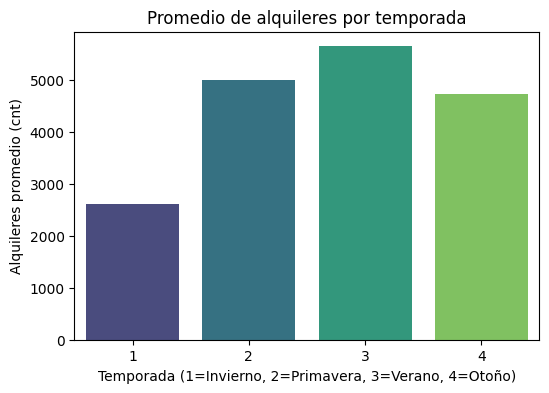

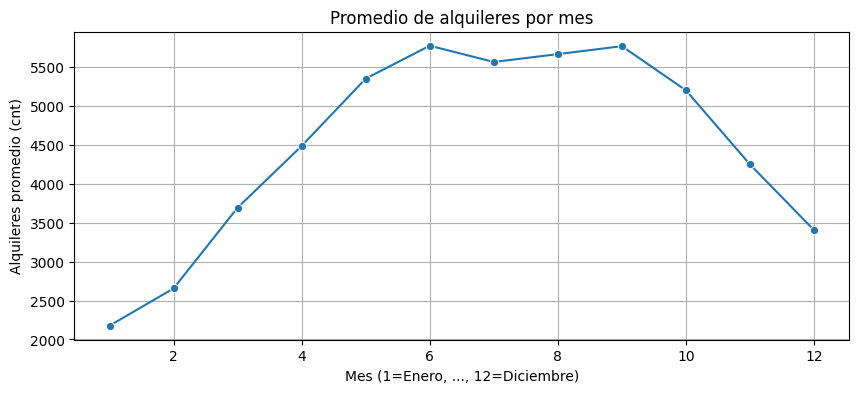

/tmp/ipython-input-1561090137.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="magma")


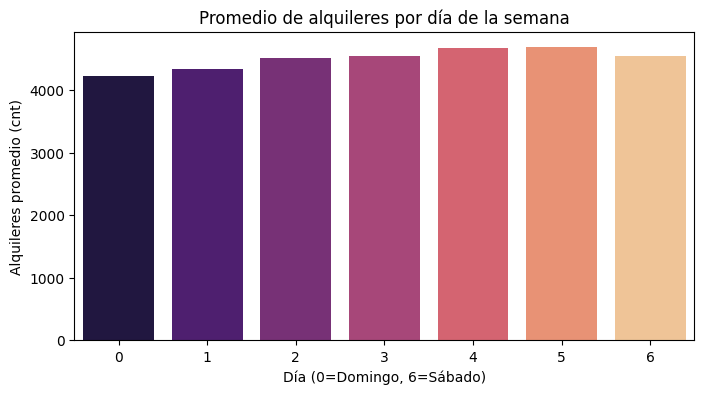

/tmp/ipython-input-1561090137.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=weather_avg.index, y=weather_avg.values, palette="coolwarm")


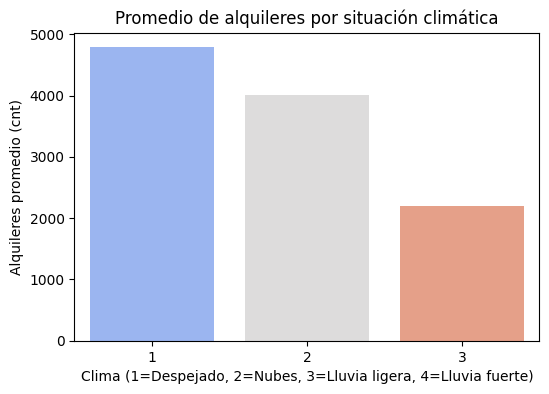

In [ ]:

# Paso 7: Análisis de efectos estacionales

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Alquileres medios por temporada
season_avg = day_df.groupby("season")["cnt"].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=season_avg.index, y=season_avg.values, palette="viridis")
plt.title("Promedio de alquileres por temporada")
plt.xlabel("Temporada (1=Invierno, 2=Primavera, 3=Verano, 4=Otoño)")
plt.ylabel("Alquileres promedio (cnt)")
plt.show()

# 2. Alquileres medios por mes
month_avg = day_df.groupby("mnth")["cnt"].mean()
plt.figure(figsize=(10,4))
sns.lineplot(x=month_avg.index, y=month_avg.values, marker="o")
plt.title("Promedio de alquileres por mes")
plt.xlabel("Mes (1=Enero, ..., 12=Diciembre)")
plt.ylabel("Alquileres promedio (cnt)")
plt.grid(True)
plt.show()

# 3. Alquileres medios por día de la semana
weekday_avg = day_df.groupby("weekday")["cnt"].mean()
plt.figure(figsize=(8,4))
sns.barplot(x=weekday_avg.index, y=weekday_avg.values, palette="magma")
plt.title("Promedio de alquileres por día de la semana")
plt.xlabel("Día (0=Domingo, 6=Sábado)")
plt.ylabel("Alquileres promedio (cnt)")
plt.show()

# 4. Efecto del clima
weather_avg = day_df.groupby("weathersit")["cnt"].mean()
plt.figure(figsize=(6,4))
sns.barplot(x=weather_avg.index, y=weather_avg.values, palette="coolwarm")
plt.title("Promedio de alquileres por situación climática")
plt.xlabel("Clima (1=Despejado, 2=Nubes, 3=Lluvia ligera, 4=Lluvia fuerte)")
plt.ylabel("Alquileres promedio (cnt)")
plt.show()


In [ ]:
# Paso 8: Predicciones finales con mejores alphas

# Mejor alpha con RidgeCV y LassoCV sobre características polinomiales
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly  = poly.transform(X_test_scaled)

alphas = np.logspace(-3, 2, 20)

ridge_poly_cv = RidgeCV(alphas=alphas, cv=5, scoring='r2')
ridge_poly_cv.fit(X_train_poly, y_train)

lasso_poly_cv = LassoCV(alphas=alphas, cv=5, max_iter=10000, random_state=42)
lasso_poly_cv.fit(X_train_poly, y_train)

# Predicciones finales
y_pred_ridge_poly = ridge_poly_cv.predict(X_test_poly)
y_pred_lasso_poly = lasso_poly_cv.predict(X_test_poly)

print("\nPredicciones finales con polinomiales:")
print("Ridge - Mejor alpha:", ridge_poly_cv.alpha_)
print("Ridge - MSE:", mean_squared_error(y_test, y_pred_ridge_poly))
print("Ridge - R²:", r2_score(y_test, y_pred_ridge_poly))

print("Lasso - Mejor alpha:", lasso_poly_cv.alpha_)
print("Lasso - MSE:", mean_squared_error(y_test, y_pred_lasso_poly))
print("Lasso - R²:", r2_score(y_test, y_pred_lasso_poly))

# Comparación de coeficientes
print("\nCoeficientes Ridge (polinomiales):")
for i, coef in enumerate(ridge_poly_cv.coef_[:20]):  # solo primeras 20 para legibilidad
    print(f"Coef {i}: {coef:.5f}")

print("\nCoeficientes Lasso (polinomiales):")
for i, coef in enumerate(lasso_poly_cv.coef_[:20]):
    if np.isclose(coef,0, atol=1e-5):
        print(f"Coef {i}: {coef:.5f} <-- reducido a cero")
    else:
        print(f"Coef {i}: {coef:.5f}")

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 261607.7321691215, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 542306.2724172473, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 588458.5861156881, tolerance: 170435.2560038544
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWar


Predicciones finales con polinomiales:
Ridge - Mejor alpha: 54.555947811685144
Ridge - MSE: 449957.483761795
Ridge - R²: 0.8877878572538478
Lasso - Mejor alpha: 29.763514416313193
Lasso - MSE: 441926.55993089656
Lasso - R²: 0.8897906401918315

Coeficientes Ridge (polinomiales):
Coef 0: 272.05268
Coef 1: 881.81414
Coef 2: 172.37424
Coef 3: -3.70301
Coef 4: 87.01639
Coef 5: 16.87909
Coef 6: -91.65749
Coef 7: 353.86543
Coef 8: 299.66842
Coef 9: -253.30902
Coef 10: -157.54891
Coef 11: -81.49728
Coef 12: 44.74601
Coef 13: -28.92890
Coef 14: 34.07377
Coef 15: 3.71003
Coef 16: -72.72777
Coef 17: 12.24401
Coef 18: -105.67728
Coef 19: -46.12825

Coeficientes Lasso (polinomiales):
Coef 0: 390.38334
Coef 1: 936.62957
Coef 2: 0.00000 <-- reducido a cero
Coef 3: -0.00000 <-- reducido a cero
Coef 4: 86.29216
Coef 5: 20.86242
Coef 6: -46.91316
Coef 7: 710.34560
Coef 8: 0.00000 <-- reducido a cero
Coef 9: -237.43714
Coef 10: -161.18225
Coef 11: -17.63215
Coef 12: 22.51999
Coef 13: 0.00000 <-- reducid

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 77522962.60254456, tolerance: 169794.32489658124
  model = cd_fast.enet_coordinate_descent_gram(
